### Loading of Images

In [1]:
from pathlib import Path
import imghdr
import os
from PIL import Image

data_dir = "hair_types"
image_extensions = [".bmp", ".gif", ".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
        # else:
        #     img = Image.open(filepath).convert('L')
        #     img.save(filepath)

/var/folders/_2/9tdd0_v908qf2_1bw_19j5wr0000gn/T/ipykernel_55326/3690981329.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Hyperparameters

In [2]:
epochs = 50
img_dimensions = (128, 128)
batch_size = 32
learning_rate = 1e-3

### Preprocessing

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    validation_split=0.2,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

train_ds = datagen.flow_from_directory(
    data_dir,
    subset="training",
    seed=1337,
    target_size=img_dimensions,
    batch_size=batch_size,
    shuffle=True,
)

val_ds = datagen.flow_from_directory(
    data_dir,
    subset="validation",
    seed=1337,
    target_size=img_dimensions,
    batch_size=batch_size, 
    shuffle=True,
)

Found 788 images belonging to 3 classes.
Found 196 images belonging to 3 classes.


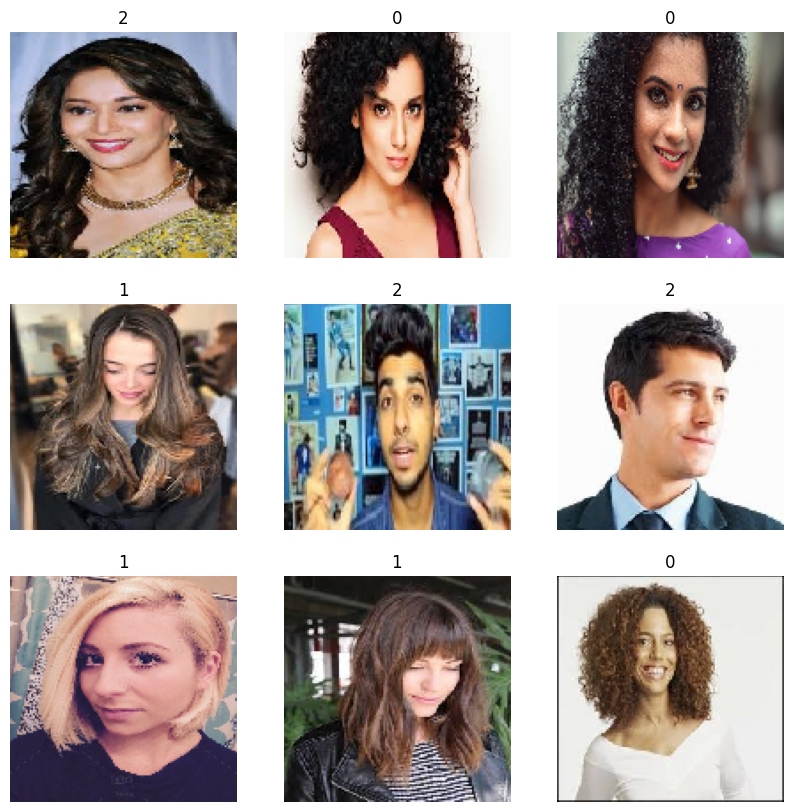

In [4]:
# looking at some sample images
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
images, labels = next(train_ds)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(int(np.argmax(labels[i])))
    plt.axis("off")
plt.show()

### Modelling

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
import pydot as pydot

model = Sequential()
model.add(keras.Input(shape=img_dimensions + (3,))) 
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(128))
model.add(layers.Activation("relu"))
model.add(layers.Dense(64))
model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 124, 124, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 124, 124, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,203 (1.13 MB)

 Trainable params: 295,203 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [6]:
def learning_rate_schedule(epoch):
    initial_lr = learning_rate
    drop = 0.1
    epochs_drop = 12
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                                tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)
                                ]
                    )

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.3373 - loss: 1.1002 - val_accuracy: 0.5153 - val_loss: 1.0731 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.4708 - loss: 1.0737 - val_accuracy: 0.4082 - val_loss: 1.0251 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.4679 - loss: 0.9980 - val_accuracy: 0.5204 - val_loss: 0.9698 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.4486 - loss: 0.9896 - val_accuracy: 0.4388 - val_loss: 0.9811 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.5292 - loss: 0.9318 - val_accuracy: 0.4745 - val_loss: 0.9609 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.5401 - loss: 0.9113 - val_accuracy: 0.4490 - val_loss: 0.9861 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.5551 - loss: 0.8827 - val_accurac

### Visualization 

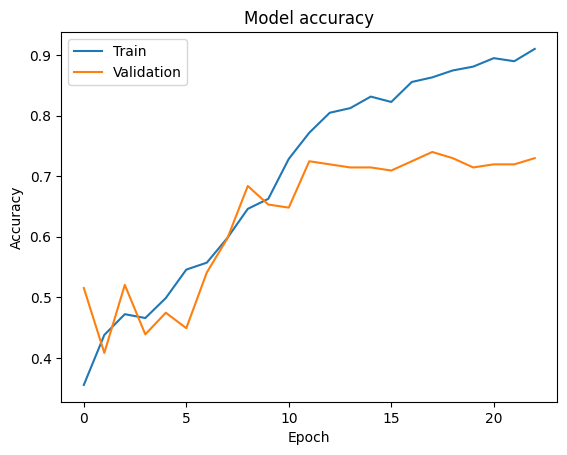

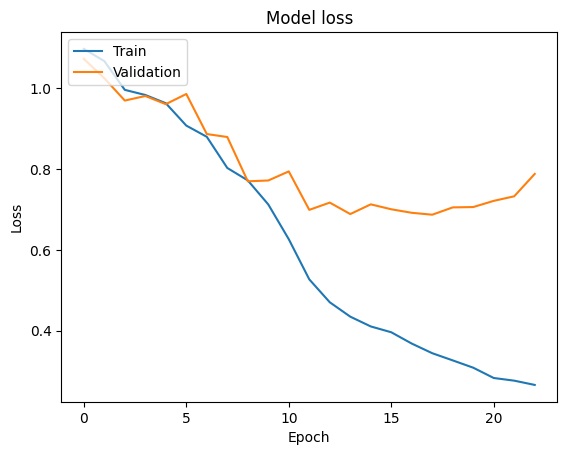

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Sample Predictions

In [9]:
val_image = val_ds  # Get one batch from the validation set
img_array, label_array = next(val_image)  # Extract the first image from the batch

# Make predictions on the image
predictions = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


This image is 0.98 percent curly hair, 0.02 percent straight hair, and 0.00 percent wavy hair.


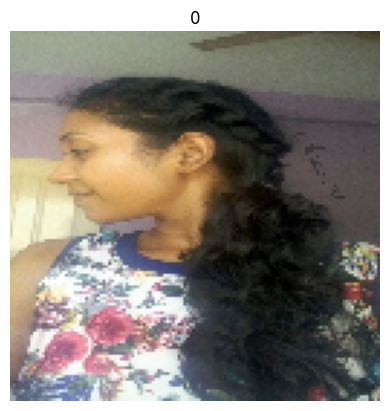

In [32]:
# curly validation example
i = 7
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[i])
)

plt.imshow(img_array[i].astype("uint8"))
plt.title(int(np.argmax(label_array[i])))
plt.axis("off")
plt.show()

This image is 0.00 percent curly hair, 0.92 percent straight hair, and 0.08 percent wavy hair.


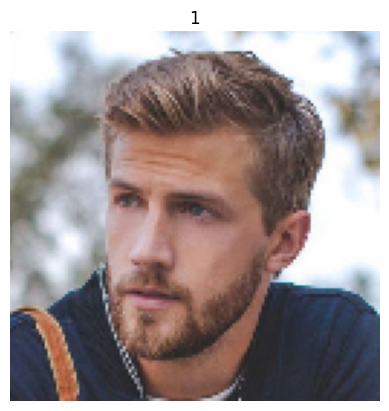

In [95]:
# straight validation example
i = 26
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[i])
)

plt.imshow(img_array[i].astype("uint8"))
plt.title(int(np.argmax(label_array[i])))
plt.axis("off")
plt.show()

This image is 0.00 percent curly hair, 0.10 percent straight hair, and 0.90 percent wavy hair.


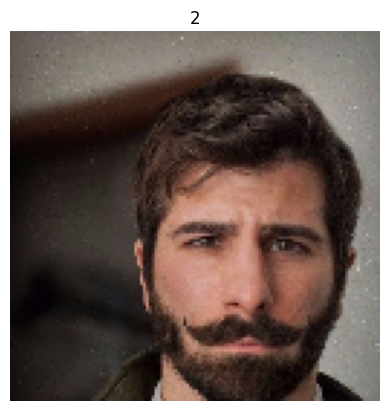

In [125]:
# straight validation example
i = 24
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[i])
)

plt.imshow(img_array[i].astype("uint8"))
plt.title(int(np.argmax(label_array[i])))
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image is 0.00 percent curly hair, 0.71 percent straight hair, and 0.29 percent wavy hair.


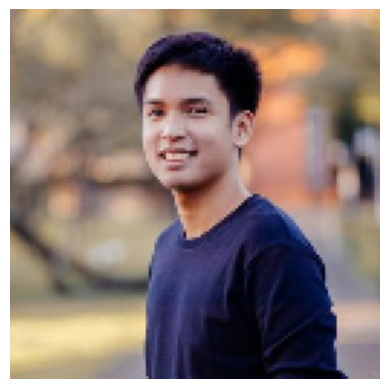

In [136]:
img = keras.preprocessing.image.load_img(
    "hair_types/sirjessie.jpg", target_size=img_dimensions
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)
plt.imshow(img)
plt.axis("off")
plt.show()


In [138]:
# Print the last epoch's performance results
print("Training Loss:", history.history['loss'][-1])
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Training Loss: 0.2654355764389038
Training Accuracy: 0.9098984599113464
Validation Loss: 0.7880910634994507
Validation Accuracy: 0.7295918464660645
